In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine
from config import load_config

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [15]:
# Loads database config values from database.ini file and validates that user and password are set.
config = load_config()
if (config['user'] == "" or config['password'] == ""):
    print("Please set your user and password in the database.ini file.")
    sys.exit(1)
    
# Creates a connection pool to PostgreSQL database using SQLAlchemy.
engine = create_engine(f"postgresql+psycopg://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}")

In [18]:
df = pd.read_sql("SELECT * FROM tstat_gene_data", engine)
df.head()

,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
0,99,Neuron_Genes_Screen,crb-1,-68.496389,-463.636579,-184.897543,-276.539960,-295.918287,-26.005262,104.180733,...,1.426824,2.924339,2.034681,4.151277,-2.125745,4.056727,7.418909,4.978237,0.754411,-0.567230
1,360,Neuron_Genes_Screen,sid-1,-303.393518,-368.376289,-414.720952,-360.376960,-287.599024,-95.889295,83.325624,...,-0.665937,0.358000,0.876437,1.640464,-0.265319,1.386822,3.147869,1.858055,1.316280,1.500438
2,15,ASD_Screen,cdkl-1,117.311452,-120.306780,16.371823,-44.065819,-21.957771,30.007247,63.061494,...,-21.382519,-3.409448,-15.418954,-15.749503,2.556072,-15.187795,-4.094371,-14.503847,-2.925680,-6.997452
3,35,ASD_Screen,gex-3,-162.011769,-209.833308,-215.668982,-34.277144,18.290498,-11.594857,-27.988780,...,0.792724,-1.161596,-1.682367,0.867141,0.755929,-1.379243,-0.374859,1.231142,-2.989971,0.132965
4,0,ASD_Screen,C25H3.11,-156.748579,-150.981109,-272.550660,28.184561,6.113967,26.840463,-28.240984,...,-5.894009,5.849083,0.411030,2.179121,0.522233,4.328581,4.220328,-1.713132,2.492574,-4.547015


In [19]:
print(f'Shape:{df.shape}')

Shape:(780, 99)


In [20]:
df.describe()

/Users/gurmehak/miniforge3/envs/rankinlab/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,index,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,Kink,Curve,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,...,779.000000,779.000000,779.000000,779.000000,776.000000,779.000000,779.000000,779.000000,766.000000,779.000000
mean,140.812821,-135.313070,-414.882377,-310.936146,-265.461395,-174.514682,-13.997782,109.406612,97.450389,1.908488,...,-1.059431,-0.177345,-0.307268,0.364911,0.772016,0.137010,1.353215,0.578235,0.670806,-0.268216
std,132.549333,182.396951,460.288656,355.502801,313.963731,209.060892,91.823357,137.501392,127.348327,172.022158,...,3.873783,4.843630,3.941579,4.692924,1.936667,5.226621,3.670393,3.833326,2.384252,1.442481
min,0.000000,-1005.656954,-2966.051419,-2721.752386,-1687.407902,-887.941204,-594.722574,-239.220612,-211.065273,-848.570463,...,-25.327189,-22.023897,-20.128498,-15.749503,-5.035088,-21.343535,-12.626542,-14.503847,-8.077057,-6.997452
25%,29.000000,-211.826723,-634.535155,-452.753546,-453.804519,-311.517939,-65.441568,1.792960,-1.643624,-93.938701,...,-2.742647,-2.567194,-2.200849,-2.220991,-0.527818,-2.559346,-0.889337,-1.936269,-0.562683,-1.122995
50%,87.000000,-84.878758,-283.226052,-212.810997,-195.291154,-149.961711,-10.348587,98.157065,88.820129,-2.147652,...,-0.555054,0.024194,-0.006218,0.621594,0.829980,0.427880,1.106600,0.466794,0.753011,-0.232950
75%,244.250000,-14.578659,-89.122935,-68.202670,-28.774768,-13.279750,43.279622,191.084866,174.983661,98.253577,...,1.042428,2.638462,1.954239,3.215768,1.721680,3.156860,3.252339,2.963633,1.816496,0.646409
max,439.000000,247.116934,281.179963,246.892884,385.971427,371.001420,247.627798,787.782873,655.452185,608.510077,...,13.148285,33.674442,16.702961,21.112297,18.237958,18.895693,21.586750,15.611046,21.327711,4.305627


In [21]:
# Accessing missingness 
df.groupby("Screen").apply(lambda x: x.isna().sum())

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_75884/779939292.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("Screen").apply(lambda x: x.isna().sum())


,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
Screen,,,,,,,,,,,,,,,,,,,,,
ASD_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
ASD_WGS_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
G-Proteins_Screen,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,2,1,1,1,2,1
Glia_Genes_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Neuron_Genes_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PD_GWAS_Locus22_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PD_GWAS_Locus71_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PD_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,6,0


In [22]:
df

,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
0,99,Neuron_Genes_Screen,crb-1,-68.496389,-463.636579,-184.897543,-276.539960,-295.918287,-26.005262,104.180733,...,1.426824,2.924339,2.034681,4.151277,-2.125745,4.056727,7.418909,4.978237,0.754411,-0.567230
1,360,Neuron_Genes_Screen,sid-1,-303.393518,-368.376289,-414.720952,-360.376960,-287.599024,-95.889295,83.325624,...,-0.665937,0.358000,0.876437,1.640464,-0.265319,1.386822,3.147869,1.858055,1.316280,1.500438
2,15,ASD_Screen,cdkl-1,117.311452,-120.306780,16.371823,-44.065819,-21.957771,30.007247,63.061494,...,-21.382519,-3.409448,-15.418954,-15.749503,2.556072,-15.187795,-4.094371,-14.503847,-2.925680,-6.997452
3,35,ASD_Screen,gex-3,-162.011769,-209.833308,-215.668982,-34.277144,18.290498,-11.594857,-27.988780,...,0.792724,-1.161596,-1.682367,0.867141,0.755929,-1.379243,-0.374859,1.231142,-2.989971,0.132965
4,0,ASD_Screen,C25H3.11,-156.748579,-150.981109,-272.550660,28.184561,6.113967,26.840463,-28.240984,...,-5.894009,5.849083,0.411030,2.179121,0.522233,4.328581,4.220328,-1.713132,2.492574,-4.547015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,108,PD_Screen,unc-43,-101.850124,-234.169230,-210.555197,44.031732,21.936045,182.856892,76.216716,...,-0.991799,-0.748966,-1.123879,-0.719720,4.944287,-2.630912,-0.460076,-0.591010,NaN,-0.616942
776,109,PD_Screen,unc-57,-166.412154,-472.028220,-511.547548,-167.244925,-36.332082,65.189587,56.701590,...,-3.715259,-2.384573,-2.884097,-5.067928,4.301016,-4.279961,-2.132468,-3.364117,NaN,-0.928510
777,110,PD_Screen,unc-59,-113.318379,-378.428538,-265.329697,-65.391543,6.282208,46.464973,234.742202,...,-4.448462,-1.820606,-1.889704,-3.729287,3.437354,-2.217888,-1.632515,-3.809516,1.169334,-0.703254
778,111,PD_Screen,unc-70,-8.909107,-576.943712,-344.383937,-89.421561,-55.103890,177.586605,488.440475,...,-3.248692,1.669532,-2.706185,-2.478294,5.994874,0.188347,-0.764557,-11.143172,0.318549,-4.243795


In [23]:
df.dtypes

index                                 int64
Screen                               object
Gene                                 object
Morphwidth                          float64
Midline                             float64
                                     ...   
Average PSA Crab                    float64
Sensitization of PSA Crab           float64
Habituation of PSA Crab             float64
Spontaneous Recovery of PSA Crab    float64
Memory Retention of PSA Crab        float64
Length: 99, dtype: object

In [24]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [25]:
df.dtypes.value_counts()

float64    96
object      2
int64       1
Name: count, dtype: int64

In [26]:
# Assessing uniqueness of categorical column

df[['Screen', 'Gene']].nunique()

Screen      8
Gene      699
dtype: int64

In [27]:
# Drop 'infs' to make sure code doesnt break 

df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

## Preprocessing 

- Imputation: choose a dummy value like -10 (for now picking -9999) - numeric only
- Scaling - numeric only
- Encoding: One Hot Encoding - categorical column only

In [28]:
df.columns

Index(['index', 'Screen', 'Gene', 'Morphwidth', 'Midline', 'Area', 'Speed',
       'Bias', 'Angular Speed', 'Aspect Ratio', 'Kink', 'Curve', 'Crab',
       'Pathlength', 'Initial Response Duration',
       'Initial Response Probability', 'Initial Response Speed',
       'Final Response Duration', 'Final Response Probability',
       'Final Response Speed', 'Habituation of Response Duration',
       'Habituation of Response Probability', 'Habituation of Response Speed',
       'Spontaneous Recovery of Response Duration',
       'Spontaneous Recovery of Response Probability',
       'Spontaneous Recovery of Response Speed',
       'Memory Retention of Response Duration',
       'Memory Retention of Response Probability',
       'Memory Retention of Response Speed', 'Initial PSA Speed',
       'Final PSA Speed', 'Recovery PSA Speed', 'Peak PSA Speed',
       'Peak Tap Number of PSA Speed', 'Average PSA Speed',
       'Sensitization of PSA Speed', 'Habituation of PSA Speed',
       'Sponta

In [29]:
# numeric_cols.value_counts().sum()

In [30]:
# Numerical columns: Impute missing values then scale
numeric_cols = df.select_dtypes(include='number').columns
si = SimpleImputer(strategy="constant", fill_value=-9999)
scaler = StandardScaler()
numerical_transformer = make_pipeline(si, scaler)

# Categorical Columns
categorical_cols = ['Screen', 'Gene']
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype = int)
categorical_transformer = make_pipeline(ohe)

# Apply transformations
preprocessor = make_column_transformer(
    (numerical_transformer, numeric_cols),
    (categorical_transformer, categorical_cols),
    remainder="passthrough" 
)

X = preprocessor.fit_transform(df)

In [31]:
# Number of new columns added

X.shape[1] - df.shape[1]

704

## Clustering

Clustering - test with 6 clusters

In [32]:
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=100)
labels = kmeans.fit_predict(X)
df['Cluster'] = labels
labels

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_75884/1809139114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = labels


array([3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 5, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,

# Elbow method to determine suitable k value

In [33]:
def plot_elbow(w, h, inertia_values, x):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, x), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h))
    ax.set_xlabel("K", fontsize=w+h)
    ax.set_ylabel("Inertia", fontsize=w+h)

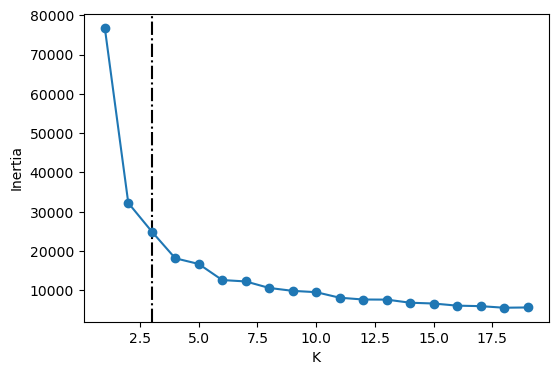

In [34]:
inertia_values = list()
x = 20
for k in range(1, x):
    inertia_values.append(KMeans(n_clusters=k, n_init='auto').fit(X).inertia_)
plot_elbow(6, 4, inertia_values, x)

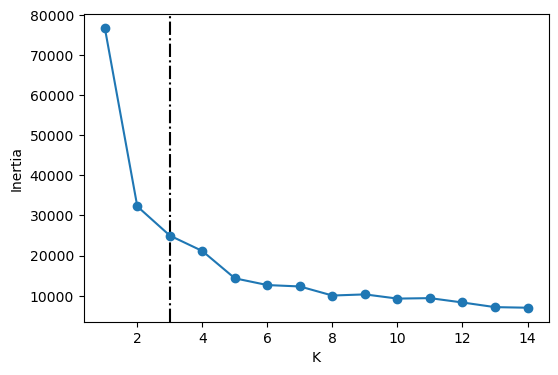

In [35]:
inertia_values = list()
x = 15
for k in range(1, x):
    inertia_values.append(KMeans(n_clusters=k, n_init='auto').fit(X).inertia_)
plot_elbow(6, 4, inertia_values, x)

Picking k = [2,6]

## Dimensionality reduction

In [36]:
print("initial shape:")
X.shape

initial shape:


(779, 803)

ValueError: x and y must have same first dimension, but have shapes (99,) and (779,)

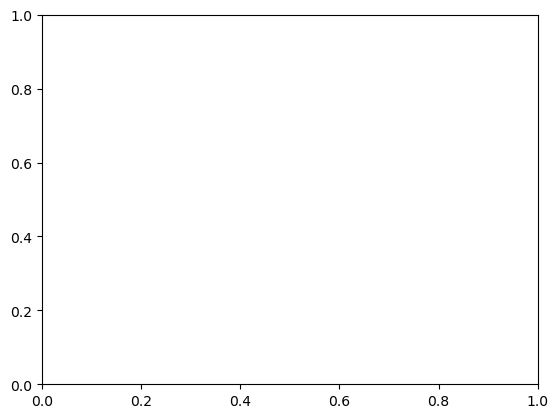

In [38]:
pca = PCA()
pca.fit(X)

import matplotlib.pyplot as plt
plt.plot(range(1, 100),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [39]:
len(pca.explained_variance_ratio_)

779

Picking 100 as the reduced dimesnion

In [40]:
pca = PCA(n_components=100)
pca_df = pca.fit_transform(X)

In [41]:
pca.explained_variance_ratio_.sum()

np.float64(0.9920685396849493)

In [42]:
pca_df.shape

(779, 100)

kmeans after PCA

In [43]:
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=100)
labels = kmeans.fit_predict(pca_df)
df['Cluster'] = labels
df

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_75884/3853737570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = labels


,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab,Cluster
0,99,Neuron_Genes_Screen,crb-1,-68.496389,-463.636579,-184.897543,-276.539960,-295.918287,-26.005262,104.180733,...,2.924339,2.034681,4.151277,-2.125745,4.056727,7.418909,4.978237,0.754411,-0.567230,3
1,360,Neuron_Genes_Screen,sid-1,-303.393518,-368.376289,-414.720952,-360.376960,-287.599024,-95.889295,83.325624,...,0.358000,0.876437,1.640464,-0.265319,1.386822,3.147869,1.858055,1.316280,1.500438,3
2,15,ASD_Screen,cdkl-1,117.311452,-120.306780,16.371823,-44.065819,-21.957771,30.007247,63.061494,...,-3.409448,-15.418954,-15.749503,2.556072,-15.187795,-4.094371,-14.503847,-2.925680,-6.997452,3
3,35,ASD_Screen,gex-3,-162.011769,-209.833308,-215.668982,-34.277144,18.290498,-11.594857,-27.988780,...,-1.161596,-1.682367,0.867141,0.755929,-1.379243,-0.374859,1.231142,-2.989971,0.132965,3
5,1,ASD_Screen,F11E6.8,-242.071763,-243.122318,-342.503847,82.767232,114.517249,40.155560,-13.700774,...,0.243976,-0.192454,-0.644696,1.677256,-0.440009,0.025463,-0.853258,0.230984,-0.420310,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,108,PD_Screen,unc-43,-101.850124,-234.169230,-210.555197,44.031732,21.936045,182.856892,76.216716,...,-0.748966,-1.123879,-0.719720,4.944287,-2.630912,-0.460076,-0.591010,NaN,-0.616942,5
776,109,PD_Screen,unc-57,-166.412154,-472.028220,-511.547548,-167.244925,-36.332082,65.189587,56.701590,...,-2.384573,-2.884097,-5.067928,4.301016,-4.279961,-2.132468,-3.364117,NaN,-0.928510,5
777,110,PD_Screen,unc-59,-113.318379,-378.428538,-265.329697,-65.391543,6.282208,46.464973,234.742202,...,-1.820606,-1.889704,-3.729287,3.437354,-2.217888,-1.632515,-3.809516,1.169334,-0.703254,2
778,111,PD_Screen,unc-70,-8.909107,-576.943712,-344.383937,-89.421561,-55.103890,177.586605,488.440475,...,1.669532,-2.706185,-2.478294,5.994874,0.188347,-0.764557,-11.143172,0.318549,-4.243795,2


In [44]:
# kmeans_df = pca_df.copy()
# kemans_df['Cluster'] = labels

Top features contributing to the clusters

In [45]:
pc1_df = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'weight': pca.components_[0]
})

pc1_df.sort_values(ascending=False, by='weight')

,feature,weight
52,pipeline-1__Average PSA Angular Speed,0.131660
36,pipeline-1__Memory Retention of PSA Speed,0.131660
47,pipeline-1__Initial PSA Angular Speed,0.131660
76,pipeline-1__Memory Retention of PSA Kink,0.131660
92,pipeline-1__Average PSA Crab,0.131660
...,...,...
99,pipeline-2__Screen_G-Proteins_Screen,-0.004619
731,pipeline-2__Gene_tir-1,-0.004704
2,pipeline-1__Midline,-0.007688
3,pipeline-1__Area,-0.007910


In [46]:
pca_df

array([[-1.06666394e+00, -9.28900042e+00, -1.14264693e+01, ...,
         5.74959922e-02,  1.44918612e-02, -3.76476611e-02],
       [-1.05736249e+00, -9.97534917e+00, -1.10166369e+01, ...,
        -1.20867509e-02, -4.27391095e-03, -6.86867801e-02],
       [-1.26939627e+00, -7.36489392e+00, -1.22722451e+01, ...,
         1.82353977e-01,  5.05753587e-02, -2.31876720e-02],
       ...,
       [ 3.84570234e-01,  2.61860106e+00, -5.30829695e-01, ...,
        -7.73363150e-02, -6.94719096e-03, -1.76301105e-02],
       [ 2.48376485e-01,  1.92378105e+00, -9.70192017e-01, ...,
        -1.36710760e-02,  5.96960212e-02, -4.37927087e-02],
       [ 3.56725920e-01,  3.04172349e+00, -7.62926578e-01, ...,
        -2.94995525e-02,  7.72814684e-02, -2.17441530e-02]],
      shape=(779, 100))

In [47]:
# plt.figure(figsize=(10, 7))
# plt.scatter(pca_df[:, 0], pca_df[:, 1], c=labels, cmap='viridis', alpha=0.5)
# plt.title('K-Means Clusters on First 2 PCA Components')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
# plt.show()

In [48]:
df["cluster"] = labels

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_75884/1245591598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = labels


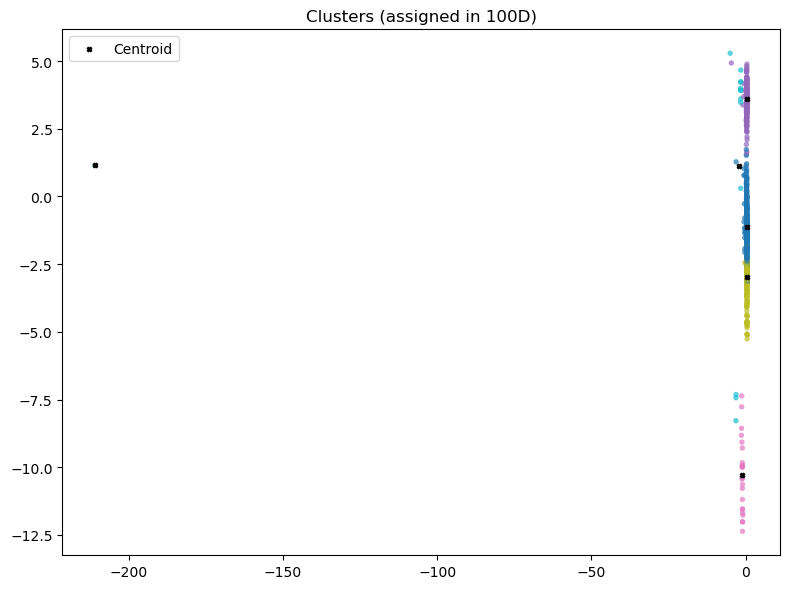

In [49]:
pca_df_vis = PCA(n_components=2, random_state=100)
labels_vis = pca_df_vis.fit_transform(pca_df)                     
centers_vis = pca_df_vis.transform(kmeans.cluster_centers_)
method = "PCA(2)"

plt.figure(figsize=(8,6))
plt.scatter(labels_vis[:, 0], labels_vis[:, 1], c=labels, cmap="tab10", alpha=0.7, s=15, linewidths=0)
plt.scatter(centers_vis[:, 0], centers_vis[:, 1], marker="X", s=10, c="black", label="Centroid")
plt.title(f"Clusters (assigned in 100D)")
# plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()


# ------------- Finish --------

In [91]:
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

numeric_cols = df.select_dtypes(include='number').columns
si = SimpleImputer(strategy="constant", fill_value=-9999)
scaler = StandardScaler()
numerical_transformer = make_pipeline(si, scaler)

# Categorical Columns
categorical_cols = ['Gene', 'Screen']
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype = int)
categorical_transformer = make_pipeline(ohe)

# Apply transformations
preprocessor = make_column_transformer(
    (numerical_transformer, numeric_cols),
    (categorical_transformer, categorical_cols),
    remainder="passthrough" 
)

X = preprocessor.fit_transform(df)

# pca = PCA()
# pca.fit(X)

# PCA + KMeans
pca = PCA(n_components=99)
pca_df = pca.fit_transform(X)

kmeans = KMeans(n_clusters=6, n_init='auto', random_state=100)
labels = kmeans.fit_predict(pca_df)

df['Cluster'] = labels

In [93]:
df.shape

(779, 101)

In [92]:
pca_df.shape

(779, 99)

# ---- TESTING VISUALIZATION METHODS -----

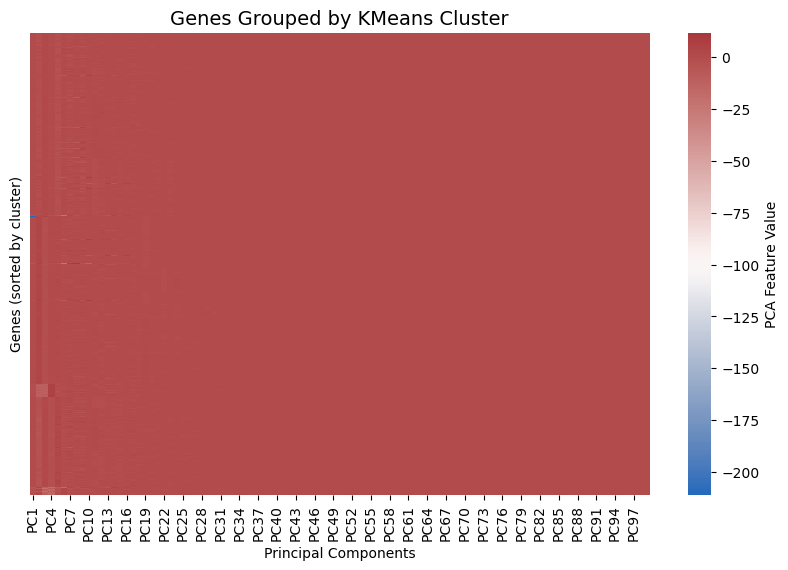

In [63]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert PCA output to DataFrame
pca_df_vis = pd.DataFrame(pca_df, index=df["Gene"], columns=[f"PC{i+1}" for i in range(pca_df.shape[1])])

# Add cluster labels
pca_df_vis["Cluster"] = labels

# Sort by cluster to group genes visually
pca_sorted = pca_df_vis.sort_values("Cluster")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pca_sorted.drop("Cluster", axis=1),
            cmap="vlag",
            yticklabels=False,
            cbar_kws={'label': 'PCA Feature Value'})
plt.title("Genes Grouped by KMeans Cluster", fontsize=14)
plt.xlabel("Principal Components")
plt.ylabel("Genes (sorted by cluster)")
plt.show()


/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_75884/1649001951.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


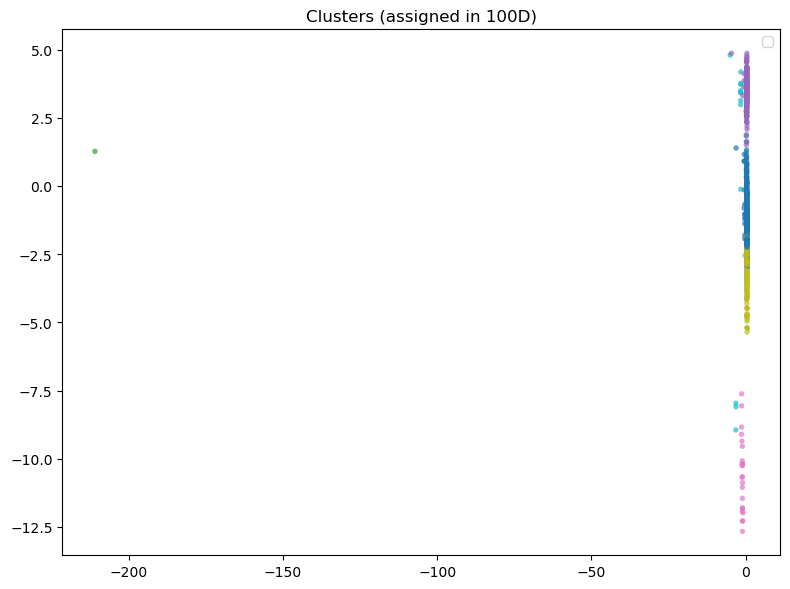

In [59]:
pca_df_vis = PCA(n_components=99, random_state=100) # n_components=2 for 2D plot
labels_vis = pca_df_vis.fit_transform(X)                     
# centers_vis = pca_df_vis.transform(kmeans.cluster_centers_)
# method = "PCA(2)"

plt.figure(figsize=(8,6))
plt.scatter(labels_vis[:, 0], labels_vis[:, 1], c=labels, cmap="tab10", alpha=0.7, s=15, linewidths=0)
# plt.scatter(centers_vis[:, 0], centers_vis[:, 1], marker="X", s=10, c="black", label="Centroid")
plt.title(f"Clusters (assigned in 100D)")
# plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()

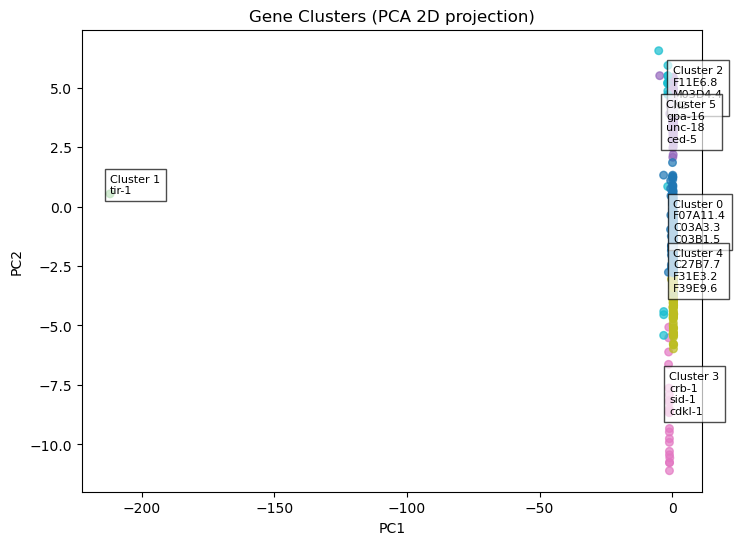

In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 components for visualization
pca_2d = PCA(n_components=2, random_state=100)
X_2d = pca_2d.fit_transform(pca_df)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
plt.title("Gene Clusters (PCA 2D projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Optional: annotate top genes per cluster
for cluster in range(len(set(labels))):
    cluster_genes = df.loc[labels == cluster, "Gene"].head(3)
    cluster_coords = X_2d[labels == cluster].mean(axis=0)
    plt.text(cluster_coords[0], cluster_coords[1], f"Cluster {cluster}\n" + "\n".join(cluster_genes),
             fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

plt.show()


<Axes: xlabel='tSNE1', ylabel='tSNE2'>

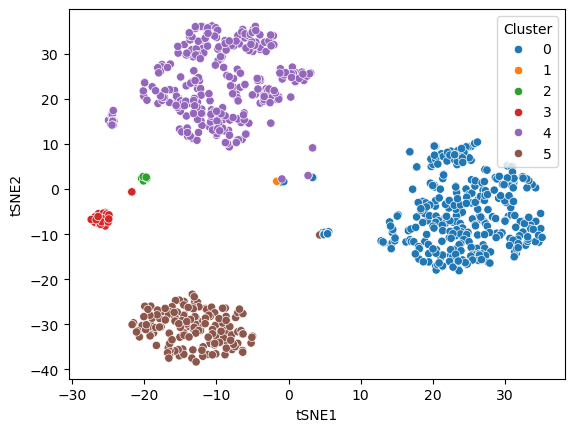

In [78]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=100)
tsne_df = pd.DataFrame(tsne.fit_transform(X), columns=['tSNE1', 'tSNE2'])
tsne_df['Cluster'] = labels
sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='Cluster', palette='tab10') 


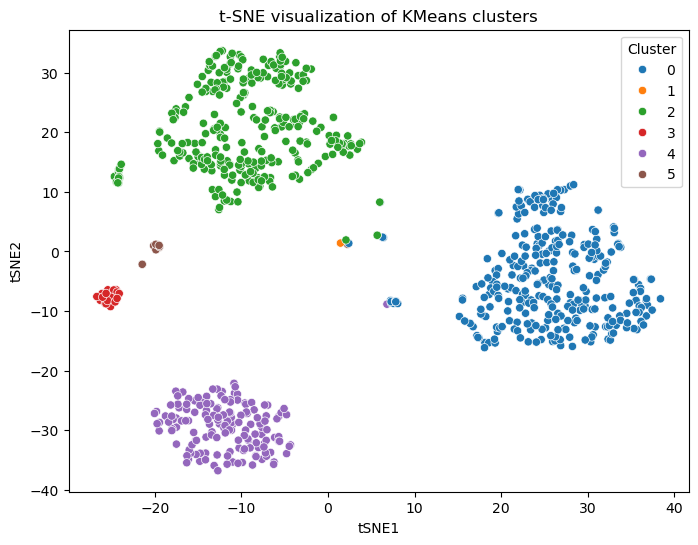

In [94]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_df = pd.DataFrame(tsne.fit_transform(pca_df), columns=['tSNE1', 'tSNE2'])
tsne_df['Cluster'] = labels

# Plot - represent high dimensionality through t-sne and cluster (colours) through kmeans
plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='Cluster', palette='tab10') 
plt.title("t-SNE visualization of KMeans clusters")
plt.show()


In [79]:
tsne_df.shape

(779, 3)

In [80]:
df.shape

(779, 101)

In [85]:
f"{df['Screen']}-{df['Gene']}"

'0      Neuron_Genes_Screen\n1      Neuron_Genes_Screen\n2               ASD_Screen\n3               ASD_Screen\n5               ASD_Screen\n              ...         \n775              PD_Screen\n776              PD_Screen\n777              PD_Screen\n778              PD_Screen\n779              PD_Screen\nName: Screen, Length: 779, dtype: object-0        crb-1\n1        sid-1\n2       cdkl-1\n3        gex-3\n5      F11E6.8\n        ...   \n775     unc-43\n776     unc-57\n777     unc-59\n778     unc-70\n779     vps-35\nName: Gene, Length: 779, dtype: object'

In [87]:
import plotly.express as px

In [97]:
tsne_df['Gene-Screen'] = df['Gene'] + "-" + df['Screen']

fig = px.scatter(
    tsne_df,
    x="tSNE1",
    y="tSNE2",
    color="Cluster",
    hover_data={"Gene-Screen": True, "Cluster": True, "tSNE1":False, "tSNE2":False},
    title="t-SNE Visualization of Gene Clusters (KMeans labels)",
    color_continuous_scale="Viridis"
)

fig.update_traces(marker=dict(size=6, opacity=0.8, line=dict(width=0)))
# fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([['crb-1-Neuron_Genes_Screen', 3],
                                   ['sid-1-Neuron_Genes_Screen', 3],
                                   ['cdkl-1-ASD_Screen', 3],
                                   ...,
                                   ['unc-57-PD_Screen', 2],
                                   ['unc-59-PD_Screen', 2],
                                   ['unc-70-PD_Screen', 2]], shape=(779, 2), dtype=object),
              'hovertemplate': 'Gene-Screen=%{customdata[0]}<br>Cluster=%{marker.color}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': {'bdata': ('AwAAAAMAAAADAAAAAwAAAAIAAAACAA' ... 'AABQAAAAUAAAACAAAAAgAAAAIAAAA='),
                                   'dtype': 'i4'},
                         'coloraxis': 'coloraxis',
                         'line': {'width': 0},
                         'opacity': 0.8,
                         'size': 6,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('zg3JweWgxcH1VsvB7YTDwZYwQ8HsnY' ... 'vBiP2ewfjxm8EdZ5DBRvS+waO/QsE='),
                    'dtype': 'f4'},
              'xaxis': 'x',
              'y': {'bdata': ('Is7mwL6f9MAd683AobTNwO2yBkKqz+' ... 'rAGviZP2iPgj8kgJFBKvhpQSRsF0E='),
                    'dtype': 'f4'},
              'yaxis': 'y'}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Cluster'}},
                             'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                            '#482878'], [0.2222222222222222,
                                            '#3e4989'], [0.3333333333333333,
                                            '#31688e'], [0.4444444444444444,
                                            '#26828e'], [0.5555555555555556,
                                            '#1f9e89'], [0.6666666666666666,
                                            '#35b779'], [0.7777777777777778,
                                            '#6ece58'], [0.8888888888888888,
                                            '#b5de2b'], [1.0, '#fde725']]},
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 't-SNE Visualization of Gene Clusters (KMeans labels)'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'tSNE1'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'tSNE2'}}}
})

ValueError: Value of 'hover_data_0' is not the name of a column in 'data_frame'. Expected one of ['tSNE1', 'tSNE2', 'Cluster', 'Gene-Screen'] but received: Gene

# ------ other methods -----

dbscan

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, metric="euclidean")
labels = clusterer.fit_predict(pca_df)  

/Users/gurmehak/miniforge3/envs/rankinlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gurmehak/miniforge3/envs/rankinlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
df["cluster2"] = labels

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_96775/2082770077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster2"] = labels


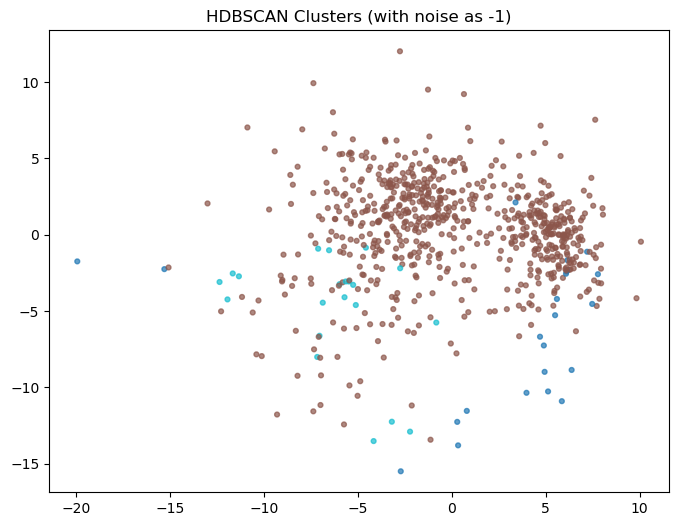

In [ ]:
pca_vis = PCA(n_components=2, random_state=100)
Z = pca_vis.fit_transform(pca_df)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=labels, cmap="tab10", s=12, alpha=0.7)
plt.title("HDBSCAN Clusters (with noise as -1)")
plt.show()

In [ ]:
# display pca1, pca2
# import plotly.express as px

# coords = PCA(n_components=2).fit_transform(X)

# pca_df = pd.DataFrame(coords, columns=["PC1","PC2"])
# pca_df["Cluster"] = labels
# pca_df["Gene"] = df["Gene"].values
# pca_df["Screen"] = df["Screen"].values

# fig = px.scatter(
#     pca_df, x="PC1", y="PC2", color="Cluster",
#     hover_data=["Gene","Screen"], opacity=0.9
# )
# fig.show()

In [ ]:
# def discrete_scatter(x1, x2, y=None, markers=None, s=8, ax=None,
#                      labels=None, padding=.2, alpha=1, c=None, markeredgewidth=0.6, 
#                      label_points=False, x1_annot=-0.1, x2_annot=0.2):
#     """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
#     Parameters
#     ----------
#     x1 : nd-array
#         input data, first axis
#     x2 : nd-array
#         input data, second axis
#     y : nd-array
#         input data, discrete labels
#     cmap : colormap
#         Colormap to use.
#     markers : list of string
#         List of markers to use, or None (which defaults to 'o').
#     s : int or float
#         Size of the marker
#     padding : float
#         Fraction of the dataset range to use for padding the axes.
#     alpha : float
#         Alpha value for all points.
#     """
#     if ax is None:
#         ax = plt.gca()

#     if y is None:
#         y = np.zeros(len(x1))        

#     # unique_y = np.unique(y)
#     unique_y, inds = np.unique(y, return_index=True)    

#     if markers is None:
#         markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

#     if len(markers) == 1:
#         markers = markers * len(unique_y)

#     if labels is None:
#         labels = unique_y

#     # lines in the matplotlib sense, not actual lines
#     lines = []


#     if len(unique_y) == 1: 
#         cr = [-1]
#     else: 
#         cr = sorted([y[index] for index in sorted(inds)])

#     if c is not None and len(c) == 1: 
#         cr = c
    
#     for (i, (yy, color_ind)) in enumerate(zip(unique_y, cr)):
#         mask = y == yy
#         # print(f'color_ind= {color_ind} and i = {i}')
#         # if c is none, use color cycle
#         color = colors[color_ind]
#         # print('color: ', color)
#         # use light edge for dark markers
#         if np.mean(colorConverter.to_rgb(color)) < .2:
#             markeredgecolor = "grey"
#         else:
#             markeredgecolor = "black"

#         lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
#                              label=labels[i], alpha=alpha, c=color,                             
#                              markeredgewidth=markeredgewidth,
#                              markeredgecolor=markeredgecolor)[0])
#     if label_points: 
#         labs = [str(label) for label in list(range(0,len(x1)))]
#         for i, txt in enumerate(labs):
#             font_size=9
#             ax.annotate(txt, (x1[i]+0.2, x2[i]+0.2), xytext= (x1[i]+x1_annot, x2[i]+x2_annot), c='k', size = font_size)

#     return lines    

# def plot_kmeans_circles(kmeans, X, n_clusters=3, ax=None):
#     km_labels = kmeans.fit_predict(X)
#     centers = kmeans.cluster_centers_
#     # plot the input data
#     ax = ax or plt.gca()
#     ax.axis('equal')
#     discrete_scatter(X[:,0], X[:,1], km_labels, c=km_labels, markers='o', markeredgewidth=0.2, ax=ax);
#     discrete_scatter(
#         centers[:, 0], centers[:, 1], y=[0,1,2], markers="*", s=18
#     );
#     radii = [cdist(X[km_labels == i], [center]).max()
#              for i, center in enumerate(centers)]
#     for center, radius in zip(centers, radii):
#         ax.add_patch(plt.Circle(center, radius, fc='gray', alpha=0.4))

In [ ]:
# import seaborn as sns

# # Create DataFrame with clusters
# df = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
# df['Cluster'] = labels

# # Scatter plot with seaborn
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x='Feature1', y='Feature2', hue='Cluster', palette='viridis')
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red')
# plt.title('K-Means Clustering with Seaborn')
# plt.show()

In [ ]:
d = pd.read_sql("SELECT * FROM tap_response_data", engine)

In [ ]:
d.head()

,Screen,dataset,Gene,Allele,Plate_id,Date,taps,plate,time,Duration,dist,Probability,Speed,PSA Speed,PSA Bias,PSA Aspect Ratio,PSA Kink,PSA Curve,PSA Crab
0,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,1.0,1.0,599.983,3.49,0.579,0.645833,0.165903,0.064750,0.157500,0.435900,68.320000,38.920000,0.010860
1,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,2.0,1.0,609.886,3.08,0.632,0.519231,0.205195,0.155022,0.441944,0.424056,68.833333,38.350000,0.022233
2,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,3.0,1.0,619.955,1.96,0.441,0.622642,0.225000,0.196569,0.761885,0.347308,56.380769,35.723077,0.023438
3,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,4.0,1.0,629.982,1.82,0.433,0.569444,0.237912,0.173472,0.796500,0.332111,53.738889,34.622222,0.019378
4,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,5.0,1.0,639.913,1.88,0.455,0.558824,0.242021,0.181033,0.818444,0.314889,51.277778,34.488889,0.019711


In [ ]:
d[d['taps']=='inf']

,Screen,dataset,Gene,Allele,Plate_id,Date,taps,plate,time,Duration,dist,Probability,Speed,PSA Speed,PSA Bias,PSA Aspect Ratio,PSA Kink,PSA Curve,PSA Crab


In [ ]:
d[d['Screen']=='ASD_Screen']['taps'].unique()

array([ 5., 15.,  6., 16.,  1.,  2.,  3.,  4.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31.])

In [ ]:
d[d['Screen']=='ASD_Screen']

,Screen,dataset,Gene,Allele,Plate_id,Date,taps,plate,time,Duration,dist,Probability,Speed,PSA Speed,PSA Bias,PSA Aspect Ratio,PSA Kink,PSA Curve,PSA Crab
41075,ASD_Screen,pax-2_ok3078,pax-2,ok3078,20190626_161516_C0626mc,20190626,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.205877,0.915825,0.280421,41.207018,32.101754,0.028354
42226,ASD_Screen,N2,N2,N2,20150516_111130_C0516ac,20150516,15.0,2.0,739.982,0.89,0.200,0.764706,0.224719,0.209274,0.868098,0.275967,46.537705,28.739344,0.016470
42467,ASD_Screen,pax-2_ok3078,pax-2,ok3078,20190626_161516_C0626mc,20190626,6.0,NaN,NaN,NaN,NaN,NaN,NaN,0.215569,0.906276,0.303103,45.151724,33.386207,0.026966
43031,ASD_Screen,N2,N2,N2,20150516_111130_C0516ac,20150516,16.0,2.0,749.984,0.39,0.099,0.478261,0.253846,0.180963,0.896952,0.295065,47.566129,31.946774,0.017098
43497,ASD_Screen,C25H3.11_gk425293,C25H3.11,gk425293,20151117_092907_B1117ba,20151117,1.0,1.0,599.931,2.98,0.558,0.941176,0.187248,0.088615,0.142758,0.424273,72.345455,37.306061,0.013364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68939,ASD_Screen,ztf-6_tm1803,ztf-6,tm1803,20160526_161911_C0526ed,20160526,27.0,5.0,859.994,1.56,0.228,0.600000,0.146154,0.059477,0.476129,0.264113,38.230645,28.759677,0.008105
68940,ASD_Screen,ztf-6_tm1803,ztf-6,tm1803,20160526_161911_C0526ed,20160526,28.0,5.0,869.960,1.45,0.237,0.250000,0.163448,0.059987,0.287565,0.236790,42.790323,27.633871,0.008202
68941,ASD_Screen,ztf-6_tm1803,ztf-6,tm1803,20160526_161911_C0526ed,20160526,29.0,5.0,879.999,1.63,0.224,0.333333,0.137423,0.055465,0.367177,0.279661,41.704839,28.587097,0.009513
68942,ASD_Screen,ztf-6_tm1803,ztf-6,tm1803,20160526_161911_C0526ed,20160526,30.0,5.0,889.958,3.43,0.656,0.333333,0.191254,0.059658,0.500258,0.315242,50.106452,29.301613,0.009466


In [ ]:
psa = pd.read_sql("SELECT * FROM psa_summarised_data", engine)
psa.head()

,Screen,dataset,Gene,Allele,Plate_id,Date,Experiment,Initial PSA Speed,Final PSA Speed,Recovery PSA Speed,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
0,PD_Screen,N2,N2,N2,20221102_154144_C1029bc,20221102,1,0.100768,0.143539,0.076825,...,0.012729,0.010293,0.010635,0.015019,4.0,0.011424,0.002291,0.004727,-16.447811,0.000342
1,PD_Screen,N2,N2,N2,20220510_183526_C0506ab,20220510,2,0.083806,0.183861,0.115679,...,0.009874,0.011680,0.016489,0.048561,2.0,0.012998,0.038687,0.036882,66.995650,0.004810
2,PD_Screen,N2,N2,N2,20220510_185420_A0506aa,20220510,3,0.100892,0.168071,0.119136,...,0.013081,0.012847,0.015069,0.021390,3.0,0.014382,0.008308,0.008543,15.197878,0.002223
3,PD_Screen,N2,N2,N2,20220510_192657_B0506ac,20220510,4,0.138958,0.145975,0.074537,...,0.017281,0.011028,0.008795,0.021743,2.0,0.012513,0.004462,0.010714,-49.106798,-0.002234
4,PD_Screen,N2,N2,N2,20220510_202509_C0506ae,20220510,5,0.126012,0.182081,0.104284,...,0.022540,0.016527,0.017939,0.026257,2.0,0.017477,0.003716,0.009729,-20.411737,0.001412


In [ ]:
psa[psa['Peak Tap Number of PSA Angular Speed']=='inf']

,Screen,dataset,Gene,Allele,Plate_id,Date,Experiment,Initial PSA Speed,Final PSA Speed,Recovery PSA Speed,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab


In [ ]:
df[df['Peak Tap Number of PSA Angular Speed']=='inf']

,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab,Cluster,cluster,cluster2


In [ ]:
df['Peak Tap Number of PSA Angular Speed'].sort_values(ascending=False)

443    12.302763
380    10.762241
729    10.471754
306    10.167823
269    10.108568
         ...    
393    -3.415650
274    -3.900067
248    -3.900067
88           NaN
97           NaN
Name: Peak Tap Number of PSA Angular Speed, Length: 731, dtype: float64

In [100]:
np.arange(2,7)

array([2, 3, 4, 5, 6])